In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.ensemble import RandomForestRegressor


In [11]:
# Load data
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")

In [12]:
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values
for strækning, station in combinations:
    print(data[(data['visualiseringskode'] == strækning) & (data['station'] == station)].shape)

(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)
(2557, 209)


In [46]:
import ast

string_tuple = '(1,0)'
tuple_result = ast.literal_eval(string_tuple)

best_model_parameters = {}
model_params_sarima = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')
list(model_params_sarima.items())
for i in range(model_params_sarima.shape[0]):
    tuple_result = ast.literal_eval(model_params_sarima['Key'][i])
    list_result = ast.literal_eval(model_params_sarima['Values'][i])
    best_model_parameters[tuple_result] = list_result

In [47]:
best_model_parameters

{(1, 0): [(1, 1, 1), (0, 0, 0, 0)],
 (2, 0): [(3, 1, 5), (0, 0, 0, 0)],
 (1, 1): [(0, 1, 2), (0, 0, 0, 0)],
 (2, 2): [(1, 1, 1), (0, 0, 0, 0)],
 (9, 2): [(1, 1, 3), (0, 0, 0, 0)],
 (10, 3): [(1, 1, 3), (0, 0, 0, 0)],
 (24, 3): [(2, 1, 1), (0, 0, 0, 0)],
 (21, 4): [(1, 1, 1), (0, 0, 0, 0)],
 (10, 5): [(5, 1, 2), (0, 0, 0, 0)],
 (8, 5): [(0, 1, 2), (0, 0, 0, 0)],
 (11, 6): [(1, 1, 3), (0, 0, 0, 0)],
 (13, 6): [(1, 1, 3), (0, 0, 0, 0)],
 (9, 6): [(1, 1, 1), (0, 0, 0, 0)],
 (1, 7): [(1, 1, 1), (0, 0, 0, 0)],
 (2, 8): [(1, 1, 1), (0, 0, 0, 0)],
 (20, 9): [(0, 1, 2), (0, 0, 0, 0)],
 (1, 10): [(1, 1, 1), (0, 0, 0, 0)],
 (17, 11): [(2, 1, 3), (0, 0, 0, 0)],
 (28, 12): [(1, 1, 3), (0, 0, 0, 0)],
 (5, 12): [(0, 1, 2), (0, 0, 0, 0)],
 (5, 13): [(1, 1, 1), (0, 0, 0, 0)],
 (6, 13): [(1, 1, 1), (0, 0, 0, 0)],
 (7, 13): [(0, 1, 2), (0, 0, 0, 0)],
 (19, 14): [(1, 1, 1), (0, 0, 0, 0)],
 (17, 15): [(0, 1, 2), (0, 0, 0, 0)],
 (11, 16): [(1, 1, 3), (0, 0, 0, 0)],
 (19, 17): [(0, 1, 2), (0, 0, 0, 0)],
 (20

In [72]:
def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
    """Generate cross-validated estimates for each input data point
    
    Parameters
    ----------
    estimator : tuple
        A tuple containing two estimators. The first estimator should be the ARIMA model
        and the second one should be the Random Forest model.

    y : array-like or iterable, shape=(n_samples,)
        The time-series array.

    X : array-like, shape=[n_obs, n_vars], optional (default=None)
        An optional 2-d array of exogenous variables.

    cv : BaseTSCrossValidator or None, optional (default=None)
        An instance of cross-validation. If None, will use a RollingForecastCV.
        Note that for cross-validation predictions, the CV step cannot exceed
        the CV horizon, or there will be a gap between fold predictions.

    verbose : integer, optional
        The verbosity level.

    averaging : str or callable, one of ["median", "mean"] (default="mean")
        Unlike normal CV, time series CV might have different folds (windows)
        forecasting the same time step. After all forecast windows are made,
        we build a matrix of y x n_folds, populating each fold's forecasts like
        so::

            nan nan nan  # training samples
            nan nan nan
            nan nan nan
            nan nan nan
              1 nan nan  # test samples
              4   3 nan
              3 2.5 3.5
            nan   6   5
            nan nan   4

        We then average each time step's forecasts to end up with our final
        prediction results.

    return_raw_predictions : bool (default=False)
        If True, raw predictions are returned instead of averaged ones.
        This results in a y x h matrix. For example, if h=3, and step=1 then:

            nan nan nan # training samples
            nan nan nan
            nan nan nan
            nan nan nan
            1   4   2   # test samples
            2   5   7
            8   9   1
            nan nan nan
            nan nan nan

        First column contains all one-step-ahead-predictions, second column all
        two-step-ahead-predictions etc. Further metrics can then be calculated
        as desired.

    Returns
    -------
    predictions : array-like, shape=(n_samples,)
        The predicted values.

    """

    def indexable(*iterables):
        """Internal utility to handle input types"""
        results = []
        for iterable in iterables:
            if not hasattr(iterable, "__iter__"):
                raise ValueError("Input {!r} is not indexable".format(iterable))
            results.append(iterable)
        return results

    def check_cv(cv, initial = 2555):
        """Internal utility to check cv"""
        if cv is None:
            from pmdarima.model_selection import RollingForecastCV
            cv = RollingForecastCV(initial=initial, step=1, h=1)
        return cv

    def check_endog(y, copy=True, preserve_series=False):
        """Internal utility to check endogenous variable"""
        from pmdarima.utils import check_endog
        return check_endog(y, copy=copy, preserve_series=preserve_series)

    def _check_averaging(averaging):
        """Internal utility to check averaging"""
        if averaging == "mean":
            return np.nanmean
        elif averaging == "median":
            return np.nanmedian
        elif callable(averaging):
            return averaging
        else:
            raise ValueError("Unknown averaging method: {}".format(averaging))

    def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=0):
        """Internal utility to fit and predict"""
        arima_model = estimator_tuple
        # Fit ARIMA model
        arima_model.fit(y[train]) # X=X.iloc[train, :]
        # Predict with ARIMA model
        train_predictions = arima_model.predict_in_sample()
        arima_pred = arima_model.predict(n_periods=len(test))

        # Calculate residuals for RF input
        arima_residuals_train = train_predictions - y[train]
        # Fit Random Forest model on ARIMA residuals
        # Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports
        D_train = xgb.DMatrix(X.iloc[train, :], label=arima_residuals_train)
        D_test = xgb.DMatrix(X.iloc[test, :], label=np.array(arima_pred) - y[test])
        # Define the parameters for the XGBoost classifier
        param = {'objective':'reg:squarederror', 'booster':'gbtree', 'max_depth': 5}
 

        steps = 20  # The number of training iterations
        watchlist = [(D_test, 'eval'), (D_train, 'train')]

        # Train the model
        model = xgb.train(param, D_train, steps, watchlist)

        # Predict the labels of the test set
        preds = model.predict(D_test)
        # Overall prediction residuals = pred - true <=> true = pred - residuals
        overall_pred = np.array(max(min(1, arima_pred[0] - preds), 0)) # make sure it is in [0;1]

        return overall_pred, test, np.array(arima_pred) #arima_residuals_test

    y, X = indexable(y, X)
    y = check_endog(y, copy=False, preserve_series=True)
    cv = check_cv(cv, initial)
    avgfunc = _check_averaging(averaging)

    if cv.step > cv.horizon:
        raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

    prediction_blocks = [
        _fit_and_predict(fold,
                         estimator,
                         y,
                         X,
                         train=train,
                         test=test,
                         verbose=verbose,)  # TODO: fit params?
        for fold, (train, test) in enumerate(cv.split(y, X))]

    pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
    arima_pred = []
    for i, (pred_block, test_indices, arima_block) in enumerate(prediction_blocks):
        pred_matrix[test_indices, i] = pred_block
        arima_pred.append(arima_block)

    if return_raw_predictions:
        predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
        for pred_block, test_indices in prediction_blocks:
            predictions[test_indices[0]] = pred_block
        return predictions

    test_mask = ~(np.isnan(pred_matrix).all(axis=1))
    predictions = pred_matrix[test_mask]



    # Calculate CV score
    cv_scores = []
    cv_scores_arima = []
    for fold, (train, test) in enumerate(cv.split(y, X)):
        fold_predictions = pred_matrix[test, fold]
        fold_score = mean_squared_error(y[test], fold_predictions)
        fold_arima_score = mean_squared_error(y[test], arima_pred[fold])
        cv_scores.append(fold_score)
        cv_scores_arima.append(fold_arima_score)

    # Compute overall CV score
    score = np.mean(cv_scores)
    arima_score = np.mean(cv_scores_arima)

    return avgfunc(predictions, axis=1), score,  arima_score


In [73]:
import warnings
warnings.filterwarnings('ignore')

results_strækning_station = {}
combinations = data[['visualiseringskode', 'station']].drop_duplicates().values
MSEs = []
MSEs_arima = []
random_state = 42


for strækning, station in combinations[:10]:
    y = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]['togpunktlighed']
    X = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)].iloc[:,1:]
    arima_model = pm.arima.ARIMA(order = best_model_parameters[strækning, station][0], seasonal_order=best_model_parameters[strækning, station][1])

    pred, mse, mse_arima = custom_cross_val_predict((arima_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=2555)
    # output = prediction per fold. 
    MSEs.append(mse)
    MSEs_arima.append(mse_arima)
    # initial = 2457 - 100 fold, 10 combinations, n_estimators=100 -> 61 min

[0]	eval-rmse:0.00440	train-rmse:0.11562
[1]	eval-rmse:0.00550	train-rmse:0.10775
[2]	eval-rmse:0.00373	train-rmse:0.10169
[3]	eval-rmse:0.00333	train-rmse:0.09691
[4]	eval-rmse:0.00139	train-rmse:0.09391
[5]	eval-rmse:0.00087	train-rmse:0.09079
[6]	eval-rmse:0.00016	train-rmse:0.08943
[7]	eval-rmse:0.00090	train-rmse:0.08849
[8]	eval-rmse:0.00051	train-rmse:0.08695
[9]	eval-rmse:0.00119	train-rmse:0.08548
[10]	eval-rmse:0.00051	train-rmse:0.08492
[11]	eval-rmse:0.00081	train-rmse:0.08436
[12]	eval-rmse:0.00266	train-rmse:0.08285
[13]	eval-rmse:0.00596	train-rmse:0.08180
[14]	eval-rmse:0.00592	train-rmse:0.08121
[15]	eval-rmse:0.00582	train-rmse:0.07900
[16]	eval-rmse:0.00643	train-rmse:0.07851
[17]	eval-rmse:0.00682	train-rmse:0.07691
[18]	eval-rmse:0.00612	train-rmse:0.07566
[19]	eval-rmse:0.00728	train-rmse:0.07445
[0]	eval-rmse:0.03248	train-rmse:0.11560
[1]	eval-rmse:0.02667	train-rmse:0.10755
[2]	eval-rmse:0.02490	train-rmse:0.10130
[3]	eval-rmse:0.02041	train-rmse:0.09674
[4]	ev

In [74]:
len(pred)

2

In [75]:
MSEs

[0.00013584342070954543,
 8.847006439415238e-06,
 0.006723028898479243,
 6.280955576620784e-05,
 0.0026751341232688765,
 0.0002619222641108494,
 8.885752424824377e-05,
 0.0013710202487617295,
 0.0011751239440438617,
 0.0022894958222407294]

In [76]:
MSEs_arima

[0.0008358243394178054,
 0.0024780247137911153,
 0.0048720357962728136,
 0.0008397847852816569,
 0.0005570491133910361,
 0.0023032198989163632,
 0.0020144005018372328,
 0.010890235864148001,
 0.002478647366939514,
 0.003086307722008111]

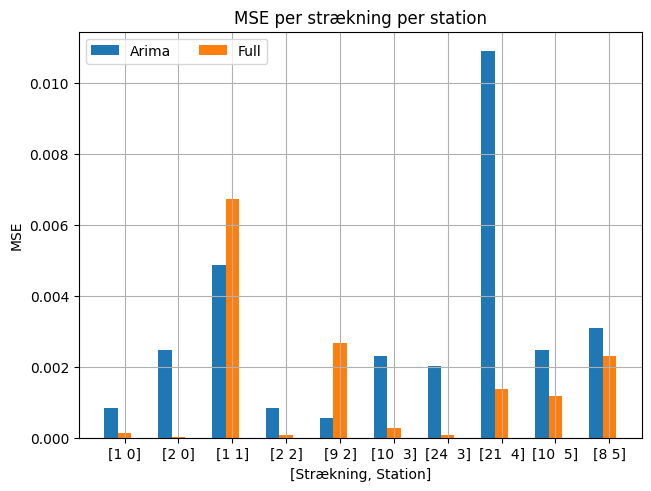

In [77]:
x = np.arange(len(MSEs))

width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in [['Arima', MSEs_arima], ['Full', MSEs]]:
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
ax.legend(loc='upper left', ncols=2)
ax.set_xticks(x + width, combinations[:10])
ax.set_xlabel('[Strækning, Station]')
ax.set_ylabel('MSE')
ax.set_title('MSE per strækning per station')
ax.grid()

In [66]:
xgb.plot_importance(model)


NameError: name 'model' is not defined